In [1]:
## https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
## https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [2]:
# Importing

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
# Reading excel and creating dataframe

df = pd.read_excel('Desktop/testoutput3.xlsx', sheet_name = 'Sheet4')
df = pd.DataFrame({'Date' : df['Date'], 'Glucose' : df['Glucose']})

In [4]:
# Checking date range
# 2016-01-05 - 2018-04-10

df['Date'].min(), df['Date'].max()

(Timestamp('2016-01-05 00:00:00'), Timestamp('2018-04-10 00:00:00'))

In [5]:
# Checking for missing values

df.isnull().sum()

Date       0
Glucose    0
dtype: int64

In [6]:
# Grouping by date
# Excluding Date = 2018-04-10, as it is an outlier

df = df.groupby('Date')['Glucose'].mean().reset_index()
df = df[df.Date != '2018-04-10']
df

,Date,Glucose
0,2016-01-05,240.000000
1,2016-01-07,90.000000
2,2016-01-09,127.000000
3,2016-01-11,98.000000
4,2016-01-13,68.000000
5,2016-01-14,80.000000
6,2016-01-15,58.000000
7,2016-01-16,108.666667
8,2016-01-26,87.000000
9,2016-01-27,76.000000


In [7]:
# Setting index

df = df.set_index('Date')
df.index

DatetimeIndex(['2016-01-05', '2016-01-07', '2016-01-09', '2016-01-11',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-26', '2016-01-27',
               ...
               '2017-12-12', '2017-12-14', '2017-12-17', '2017-12-18',
               '2017-12-20', '2017-12-21', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Date', length=429, freq=None)

In [8]:
# Resampling by month

y = df['Glucose'].resample('MS').mean()
y

Date
2016-01-01    101.196970
2016-02-01     92.766667
2016-03-01     93.750000
2016-04-01     97.710526
2016-05-01     83.361111
2016-06-01     82.694118
2016-07-01    103.140351
2016-08-01     85.076923
2016-09-01     93.166667
2016-10-01     91.452381
2016-11-01    112.772727
2016-12-01     96.601852
2017-01-01    112.054386
2017-02-01     96.754010
2017-03-01     97.482091
2017-04-01     87.375000
2017-05-01     96.333333
2017-06-01     94.947368
2017-07-01    100.301389
2017-08-01    103.152000
2017-09-01     91.052632
2017-10-01     95.822917
2017-11-01    107.543860
2017-12-01     92.558333
Freq: MS, Name: Glucose, dtype: float64

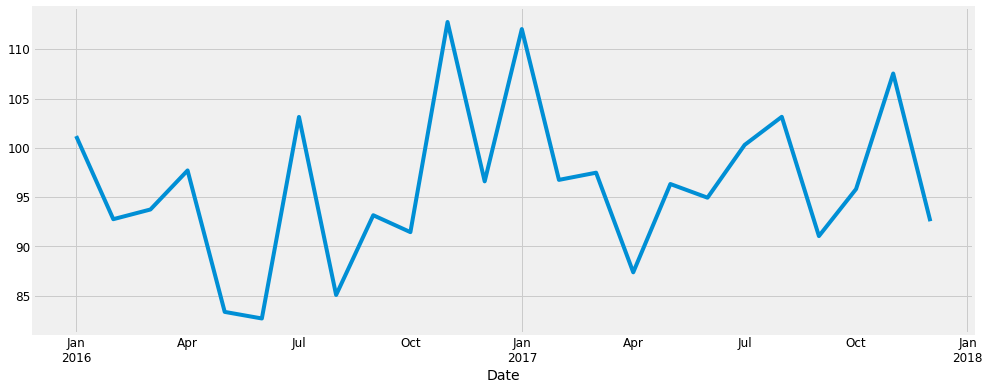

In [9]:
# Plotting y

y.plot(figsize=(15, 6))
plt.show()

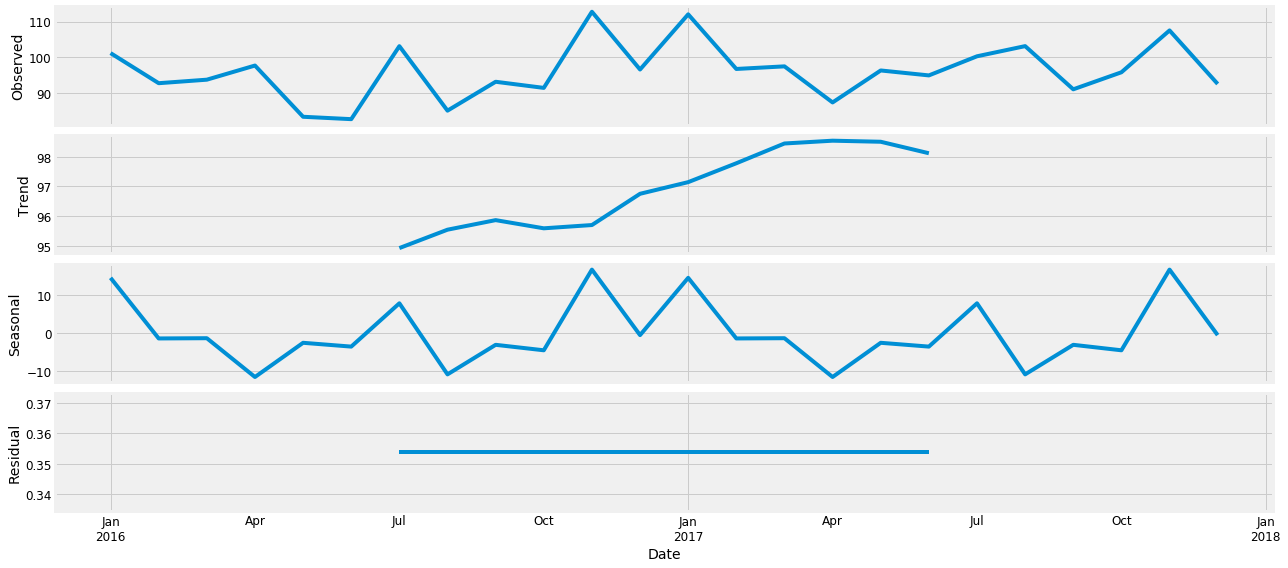

In [10]:
# Trend, Seasonality, and Noise

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
# Autoregressive Integrated Moving Average (ARIMA)
# ARIMA(p, d, q)
    ## p = Seasonality
    ## d = Trend
    ## q = Noise

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [12]:
# Parameter Selection
# AIC is an estimator of the quality of each model, relative to other models.

for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order = param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity = False, 
                                            enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:277.3811413321408
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:81.12891513769861
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:89.45378653129924
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:245.24846524907576
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:76.52546576729031
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:89.99439164151048
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:172.4041093458087
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:83.10931230811774
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:83.62121551844233
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:154.27649696410037
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:71.28582519635897
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:80.38742699461089
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:181.4734700993292
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:83.01801898771924
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:84.90905949721065
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:161.5110181137824
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:78.33842567383613
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:81.61479420824065
ARIMA(1,

In [13]:
# Fitting the ARIMA model with the lowest AIC value.
#ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:83.01801898771924

# coef = Importance of each feature
# P>|z| = Significance of each feature weight

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0947      0.330     -0.287      0.774      -0.742       0.553
sigma2        77.1367     37.523      2.056      0.040       3.592     150.681


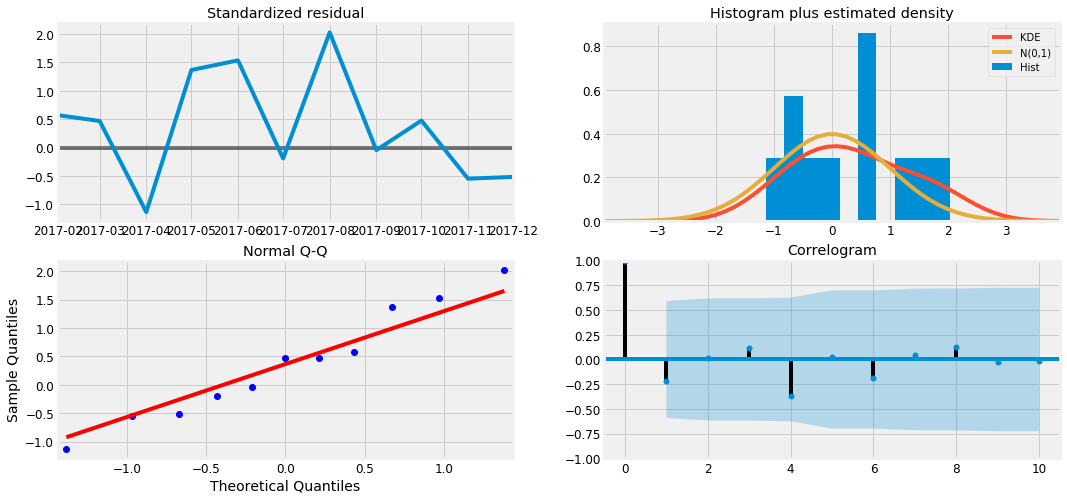

In [14]:
# Running model diagnostics
#
# Identify seasonal patterns for the year
#
# Red KDE line follows closely with the N(0,1) line, indicating that the
# residuals are normally distributed.
# N(0,1) is the standard notation for a normal distribution with mean 0 and sd 1 
#
# Normal Q-Q plot shows the distribution of residuals (dots) following the
# trend of the standard normal distribution with N(0,1).
#
# Correlation of the residuals and lagged versions of itself


results.plot_diagnostics(figsize=(16, 8))
plt.show()

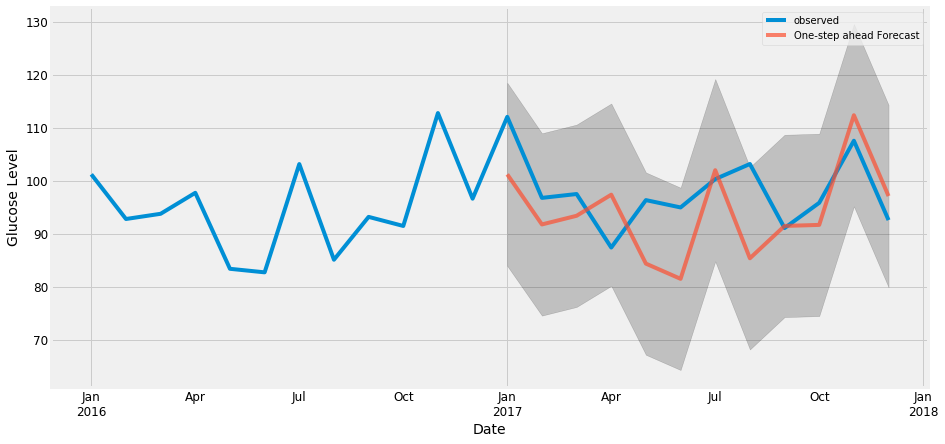

In [15]:
# Comparing One-Step ahead forecast against real Glucose level
# starting from 2017-01-01

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Glucose Level')
plt.legend()
plt.show()

In [16]:
# Mean Squared Error (MSE) is an estimator to measures the average of the 
# square of the errors.
# The smaller the MSE, the closer we are to finding the line of best fit.

y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 80.53


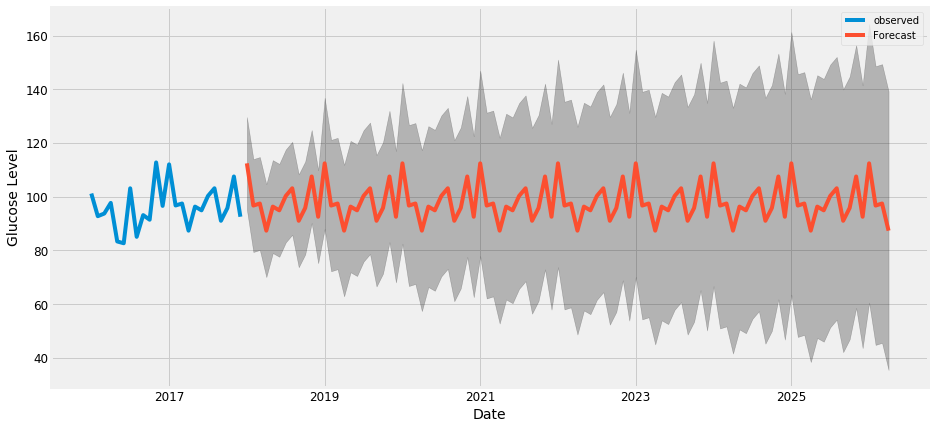

In [17]:
# Producing and visualizing forecasts
# As we forecast further out into the future, the values will 
# become less confident.

pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Glucose Level')
plt.legend()
plt.show()